In [36]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy
import statsmodels.formula.api as smf

import tasks.stats
import tasks.postprocessing
import tasks.graphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

In [38]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [39]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57470,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57471,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57472,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57473,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


In [40]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [41]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


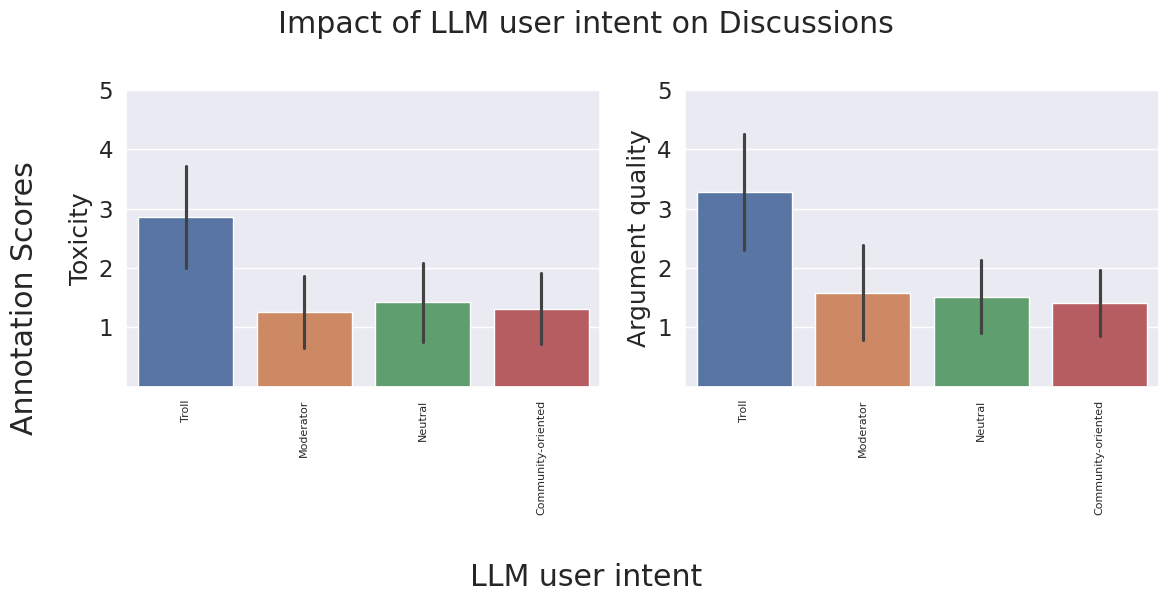

In [42]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


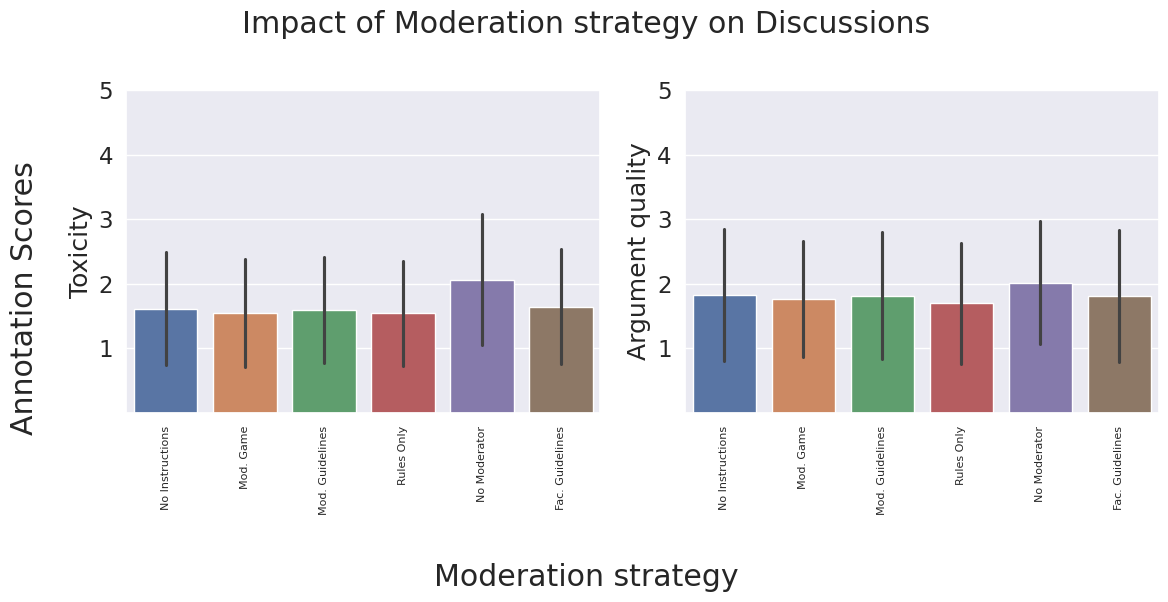

In [43]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


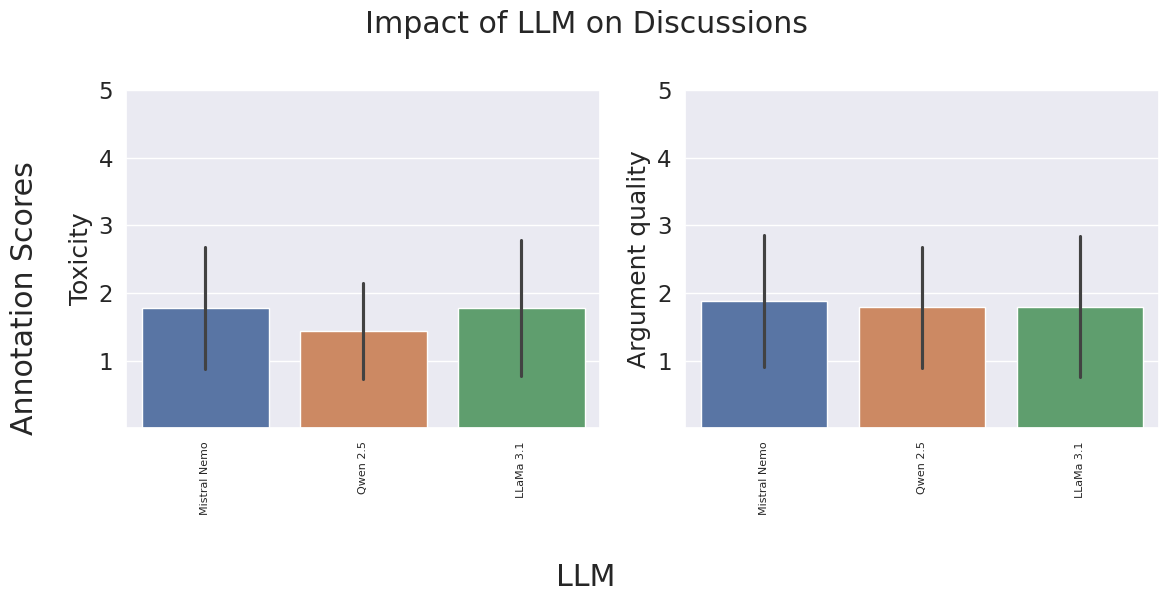

In [44]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Toxicity by model

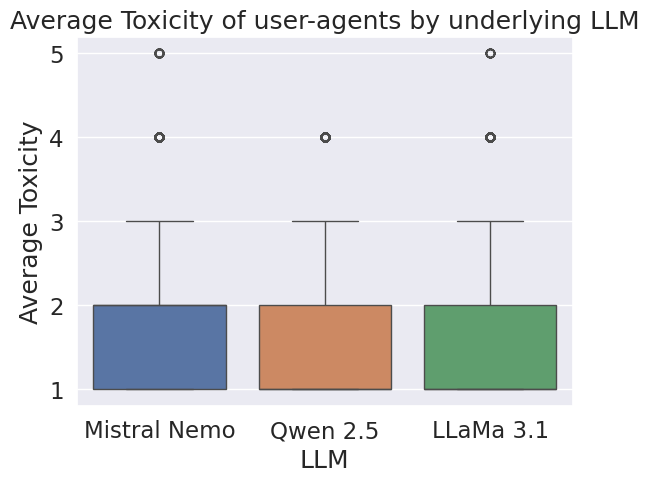

In [45]:
sns.boxplot(data=no_mod_df, x="model", y="Toxicity", hue="model")
plt.title("Average Toxicity of user-agents by underlying LLM")
plt.ylabel("Average Toxicity")
plt.xlabel("LLM")
plt.legend("", frameon=False)
plt.show()

In [46]:
groups = [
    no_mod_df[no_mod_df.model == model].Toxicity.values
    for model in no_mod_df.model.unique()
]
scipy.stats.f_oneway(*groups)

F_onewayResult(statistic=345.55022794606737, pvalue=1.958342645263061e-148)

In [47]:
sp.posthoc_ttest(
    no_mod_df, val_col="Toxicity", group_col="model", p_adjust="holm"
)

,Mistral Nemo,Qwen 2.5,LLaMa 3.1
Mistral Nemo,1.000000e+00,5.725389e-134,9.449206e-01
Qwen 2.5,5.725389e-134,1.000000e+00,6.148880e-114
LLaMa 3.1,9.449206e-01,6.148880e-114,1.000000e+00


In [48]:
[
    no_mod_df[no_mod_df.model == model].Toxicity.mean()
    for model in no_mod_df.model.unique()
]

[1.7760793778492894, 1.4371403912543153, 1.7749858836815358]

## Goad

In [49]:
def conv_trolls_exist(df: pd.DataFrame) -> pd.DataFrame:
    trolls_exist = (
        df.groupby("conv_id")["intent"]
        .apply(lambda x: np.any(x == "Troll"))
        .reset_index()
    )
    trolls_exist = trolls_exist.rename(columns={"intent": "trolls_exist"})
    df = df.merge(trolls_exist, on="conv_id")
    df = df[df.intent != "Troll"]
    df = df[df.model != "hardcoded"]
    return df

In [50]:
finetuned_df = conv_trolls_exist(no_mod_df)
finetuned_df = finetuned_df[finetuned_df.model == "Qwen 2.5"]
finetuned_df["instructions"] = "finetuned"
finetuned_df.head()

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist,instructions
187,11d555f4-f5e4-4f64-a0cd-f89f2b29553d,1566302090519499682,2,No Instructions,Qwen 2.5,EnergeticCoach77,You are a human participating in an online cha...,False,Community-oriented,"@HumbleFarmer12, I have to strongly disagree w...",1,2,False,True,finetuned
188,11d555f4-f5e4-4f64-a0cd-f89f2b29553d,1566302090519499682,2,No Instructions,Qwen 2.5,EnergeticCoach77,You are a human participating in an online cha...,False,Community-oriented,"@HumbleFarmer12, I have to strongly disagree w...",3,2,False,True,finetuned
189,11d555f4-f5e4-4f64-a0cd-f89f2b29553d,1566302090519499682,2,No Instructions,Qwen 2.5,EnergeticCoach77,You are a human participating in an online cha...,False,Community-oriented,"@HumbleFarmer12, I have to strongly disagree w...",2,2,False,True,finetuned
190,11d555f4-f5e4-4f64-a0cd-f89f2b29553d,1566302090519499682,2,No Instructions,Qwen 2.5,EnergeticCoach77,You are a human participating in an online cha...,False,Community-oriented,"@HumbleFarmer12, I have to strongly disagree w...",3,2,False,True,finetuned
191,11d555f4-f5e4-4f64-a0cd-f89f2b29553d,1566302090519499682,2,No Instructions,Qwen 2.5,EnergeticCoach77,You are a human participating in an online cha...,False,Community-oriented,"@HumbleFarmer12, I have to strongly disagree w...",1,2,False,True,finetuned


In [51]:
basic_instr_df = pd.read_csv(
    "../data/datasets/annotator_ablation/abl_no_instructions_toxicity.csv"
)
basic_instr_df = tasks.postprocessing.format_dataset(
    basic_instr_df, min_message_len=1
)
basic_instr_df = basic_instr_df[~basic_instr_df.is_moderator]
basic_instr_df = conv_trolls_exist(basic_instr_df)
basic_instr_df["instructions"] = "basic"
basic_instr_df.head()

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist,instructions
11,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,1731442744253093660,2,nan,Qwen 2.5,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@EmpatheticNurse45, I can see where you're com...",3,2,False,True,basic
12,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,1731442744253093660,2,nan,Qwen 2.5,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@EmpatheticNurse45, I can see where you're com...",3,2,False,True,basic
13,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,1731442744253093660,2,nan,Qwen 2.5,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@EmpatheticNurse45, I can see where you're com...",3,2,False,True,basic
14,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,1731442744253093660,2,nan,Qwen 2.5,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@EmpatheticNurse45, I can see where you're com...",3,2,False,True,basic
15,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,1731442744253093660,2,nan,Qwen 2.5,CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@EmpatheticNurse45, I can see where you're com...",3,2,False,True,basic


In [52]:
all_troll_df = pd.concat([finetuned_df, basic_instr_df]).loc[
    :, ["Toxicity", "Argument Quality", "instructions", "trolls_exist"]
]
all_troll_df.head()

,Toxicity,Argument Quality,instructions,trolls_exist
187,1,2,finetuned,True
188,3,2,finetuned,True
189,2,2,finetuned,True
190,3,2,finetuned,True
191,1,2,finetuned,True


<Axes: xlabel='Toxicity', ylabel='Count'>

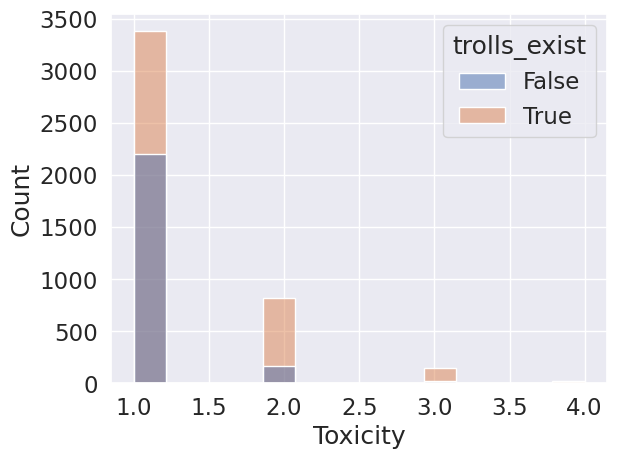

In [53]:
sns.histplot(all_troll_df, x="Toxicity", hue="trolls_exist")

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_trolls.png


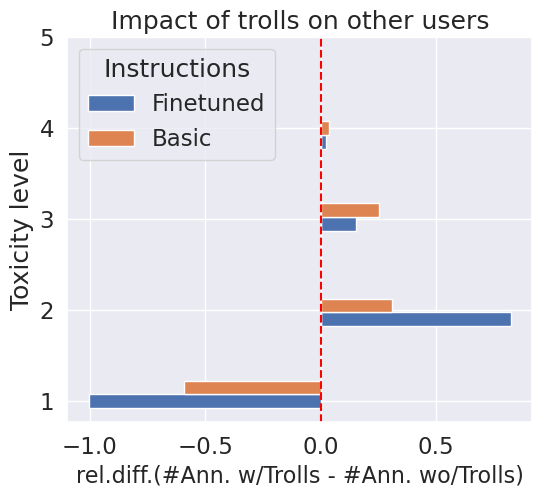

In [54]:
tasks.graphs.difference_histogram(all_troll_df, feature="Toxicity")
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "toxicity_trolls.png"
)
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/aq_trolls.png


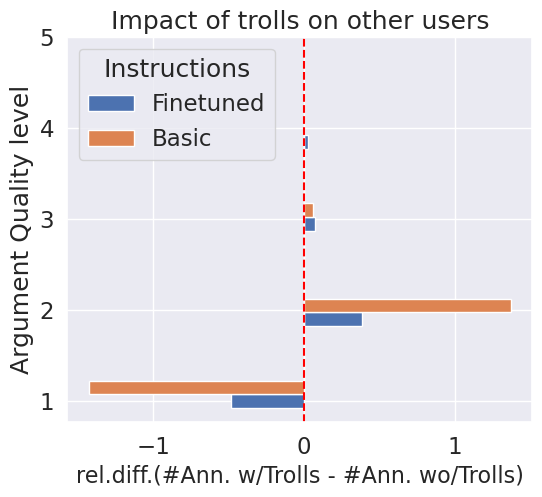

In [55]:
tasks.graphs.difference_histogram(all_troll_df, feature="Argument Quality")
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "aq_trolls.png"
)
plt.show()

## Annotator SDB impact

In [56]:
no_sdb_annotated_df = pd.read_csv(
    "../data/datasets/annotator_ablation/abl_annot_basic_instructions.csv"
)
no_sdb_annotated_df = tasks.postprocessing.format_dataset(
    no_sdb_annotated_df, min_message_len=1
)
no_sdb_annotated_df.head()

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,-491027229512695387,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,5,5,False
1,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,-491027229512695387,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False
2,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,-491027229512695387,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,4,5,False
3,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,-491027229512695387,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,5,5,False
4,0a9589fe-96fe-4dc3-9edc-a1d6021d057a,-491027229512695387,1,nan,hardcoded,EmpatheticNurse45,You are a human participating in an online cha...,False,Neutral,well thats a no brainer hillary clinton gave h...,5,5,False


## Annotator analysis

### SDB impact on annotators

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/sdb_toxicity.png


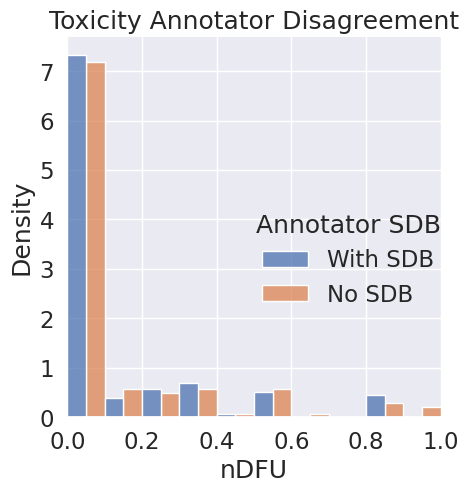

In [57]:
sdb_annotated_df = full_df[
    (full_df.conv_variant == "No Instructions") & (full_df.model == "Qwen 2.5")
]
sdb_toxicity_var = tasks.stats.discussion_var(
    sdb_annotated_df, "conv_id", "message_id", "Toxicity"
)

no_sdb_toxicity_var = tasks.stats.discussion_var(
    no_sdb_annotated_df, "conv_id", "message_id", "Toxicity"
)

tasks.graphs.disagreement_plot(
    var_with_sdb=sdb_toxicity_var,
    var_no_sdb=no_sdb_toxicity_var,
    title="Toxicity Annotator Disagreement",
    stat_col="Toxicity",
)

tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "sdb_toxicity.png"
)
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/sdb_aq.png


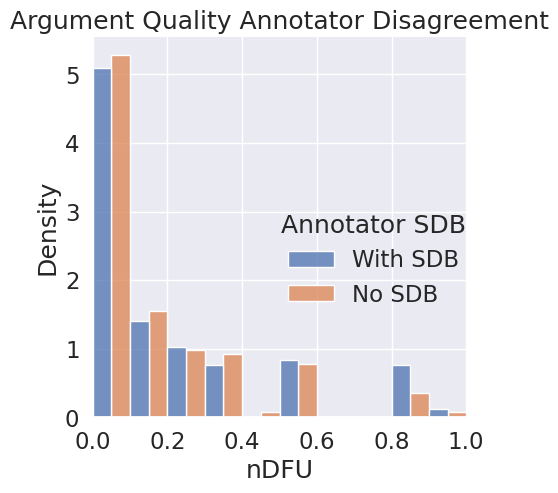

In [58]:
sdb_toxicity_var = tasks.stats.discussion_var(
    sdb_annotated_df, "conv_id", "message_id", "Argument Quality"
)

no_sdb_toxicity_var = tasks.stats.discussion_var(
    no_sdb_annotated_df, "conv_id", "message_id", "Argument Quality"
)

tasks.graphs.disagreement_plot(
    var_with_sdb=sdb_toxicity_var,
    var_no_sdb=no_sdb_toxicity_var,
    title="Argument Quality Annotator Disagreement",
    stat_col="Argument Quality",
)
tasks.graphs.save_plot(path=tasks.constants.GRAPH_OUTPUT_DIR / "sdb_aq.png")
plt.show()

### Toxicity-nDFU correlation

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/ndfu_toxicity.png


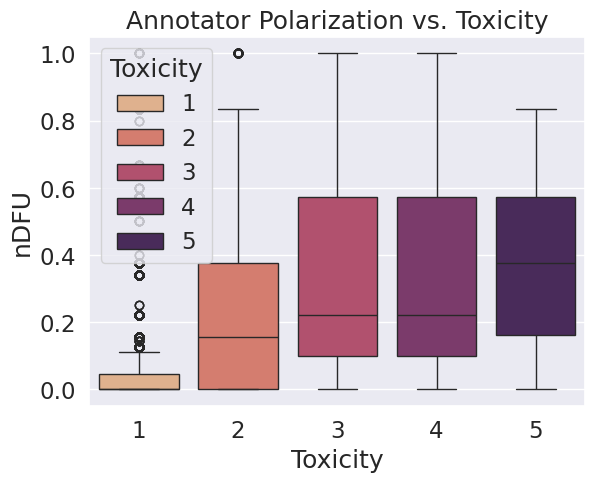

In [59]:
tasks.graphs.polarization_plot(full_df, metric_col="Toxicity")
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR / "ndfu_toxicity.png"
)
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/ndfu_aq.png


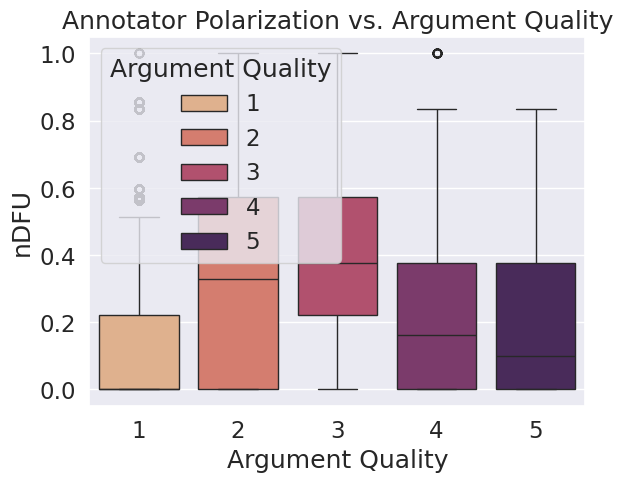

In [60]:
tasks.graphs.polarization_plot(full_df, metric_col="Argument Quality")
tasks.graphs.save_plot(path=tasks.constants.GRAPH_OUTPUT_DIR / "ndfu_aq.png")
plt.show()

In [61]:
toxicity_ndfu_df = tasks.stats.polarization_df(full_df, metric_col="Toxicity")

model = smf.ols(
    "polarization ~ Toxicity",
    data=toxicity_ndfu_df.rename({"Argument Quality": "arg_quality"}, axis=1),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           polarization   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                 1.655e+04
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        11:13:07   Log-Likelihood:                 15409.
No. Observations:               57475   AIC:                        -3.081e+04
Df Residuals:                   57473   BIC:                        -3.080e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0540      0.002    -34.193      0.000      -0.057      -0.051
Toxicity       0.1206      0.001    128.640      0.000       0.119       0.122
==============================================================================
Omnibus:                    20674.038   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77582.724
Skew:                           1.799   Prob(JB):                         0.00
Kurtosis:                       7.410   Cond. No.                         4.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
aq_ndfu_df = tasks.stats.polarization_df(
    full_df, metric_col="Argument Quality"
).rename({"Argument Quality": "arg_quality"}, axis=1)

model = smf.ols("polarization ~ arg_quality", data=aq_ndfu_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           polarization   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2435.
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        11:13:07   Log-Likelihood:                -8029.9
No. Observations:               57475   AIC:                         1.606e+04
Df Residuals:                   57473   BIC:                         1.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1345      0.002     55.117      0.000       0.130       0.139
arg_quality     0.0613      0.001     49.350      0.000       0.059       0.064
==============================================================================
Omnibus:                     6571.194   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8733.065
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                       2.671   Cond. No.                         5.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""